# Recommendation for Tariff

# Brief Description

Task: You have data on customer behavior who have already transitioned to these tariffs (from the "Statistical Data Analysis" course project). Build a classification model that selects the appropriate tariff. Data preprocessing is not needed, as it has already been done.

Goal: Build a model with the highest possible accuracy. Aim to achieve an accuracy rate of at least 0.75.

In [ ]:

import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

## Exploring the Dataset

In [ ]:

data = pd.read_csv('/datasets/users_behavior.csv')
data

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [ ]:
data['calls'] = data['calls'].astype('int')
data['messages'] = data['messages'].astype('int')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [ ]:
# Checking Class Balance:
print(data['is_ultra'].sum() / data['is_ultra'].count())

0.30647168637212197


In [ ]:
# Suspicions of Feature Correlation:
print(data.corr())

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


In [ ]:
# Removing the column to eliminate multicollinearity:
del data['minutes']

print(data)

      calls  messages   mb_used  is_ultra
0        40        83  19915.42         0
1        85        56  22696.96         0
2        77        86  21060.45         0
3       106        81   8437.39         1
4        66         1  14502.75         0
...     ...       ...       ...       ...
3209    122        20  35124.90         1
3210     25         0   3275.61         0
3211     97        70  13974.06         0
3212     64        90  31239.78         0
3213     80         6  29480.52         1

[3214 rows x 4 columns]


**Conclusion:**

There were no issues with opening the file. Data preprocessing had been completed earlier. I decided to change the data type of the `calls` and `messages` columns to `int` because these columns contain natural numbers. I noticed a class imbalance with a ratio of 3:7, which means the model will need to be checked for adequacy. There was a strong correlation between the `calls` and `minutes` features, which could lead to decreased model accuracy. To address this issue, it was decided to remove the `minutes` column.

## Splitting the Data into Train and Test Sets

The same seed, 404540, was used for all `random_state` values to ensure reproducibility of the results.

In [ ]:
# Splitting the data and obtaining:

target = data['is_ultra']
features = data.drop('is_ultra', axis=1)
features_train, features_vaild_test, target_train, target_valid_test =\
train_test_split(features, target, test_size = 0.4,random_state=404540,
                 stratify=target)
features_valid, features_test, target_valid, target_test = \
train_test_split(features_vaild_test, target_valid_test, test_size=0.5,
                 random_state=404540, stratify=target_valid_test)


# Checking the Split:
test_shape = [target_train, features_train, target_valid, 
              features_valid, target_test, features_test]

for i in test_shape:
  print(i.shape)


(1928,)
(1928, 3)
(643,)
(643, 3)
(643,)
(643, 3)


**Conclusion:**

I split the entire dataset into three random samples in a 1:1:3 ratio - test set : validation set : training set.

## Model Exploration

In [ ]:
# Investigating Model Overfitting:
acc_train = []
acc_valid = []
for i in range(1, 20):
  model = DecisionTreeClassifier(random_state=404540, max_depth=i)
  model.fit(features_train, target_train)
  predictions_train = model.predict(features_train)
  acc_train.append(accuracy_score(target_train, predictions_train))
  predictions_valid = model.predict(features_valid)
  acc_valid.append(accuracy_score(target_valid, predictions_valid))

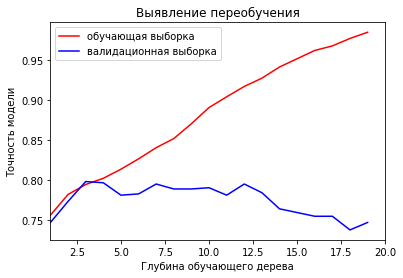

In [ ]:
plt.plot(range(1, 20), acc_train, color='red', label='обучающая выборка')
plt.plot(range(1, 20), acc_valid, color='blue', label='валидационная выборка')
plt.xlabel('Глубина обучающего дерева')
plt.ylabel('Точность модели')
plt.title('Выявление переобучения')
plt.xlim(1, 20)
plt.legend()
plt.show()

We observe that as the model trains, its accuracy improves on both the training and validation sets. However, we see that at a depth of approximately 3, the accuracy on the validation set reaches its peak and then starts to decline, indicating that the model is overfitting.

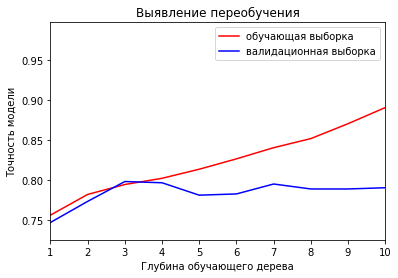

In [ ]:
plt.plot(range(1, 20), acc_train, color='red', label='обучающая выборка')
plt.plot(range(1, 20), acc_valid, color='blue', label='валидационная выборка')
plt.xlabel('Глубина обучающего дерева')
plt.ylabel('Точность модели')
plt.title('Выявление переобучения')
plt.xlim(1, 10)
plt.legend()
plt.show()

Let's zoom in. Indeed, at a depth of 3, we see a decline. From the analysis, we conclude that the optimal depth is 3.

In [ ]:
# Investigating the Effectiveness of the Decision Tree:
best_acc = 0

for samples_split in range(2, 6):
    for min_featur in [None, 'auto', 'sqrt', 'log2']:
        for weight in [None, 'balanced']:
            model = DecisionTreeClassifier(
                random_state=404540, max_depth=3,
                min_samples_split=samples_split, 
                max_features=min_featur, class_weight=weight)
            model.fit(features_train, target_train)
            prediction = model.predict(features_valid)
            acc = accuracy_score(target_valid, prediction)
            if acc > best_acc:
                best_model = model
                best_acc = acc
                best_depth = i

/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9

In [ ]:
print(best_model)
print(best_acc)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       random_state=404540)
0.7993779160186625


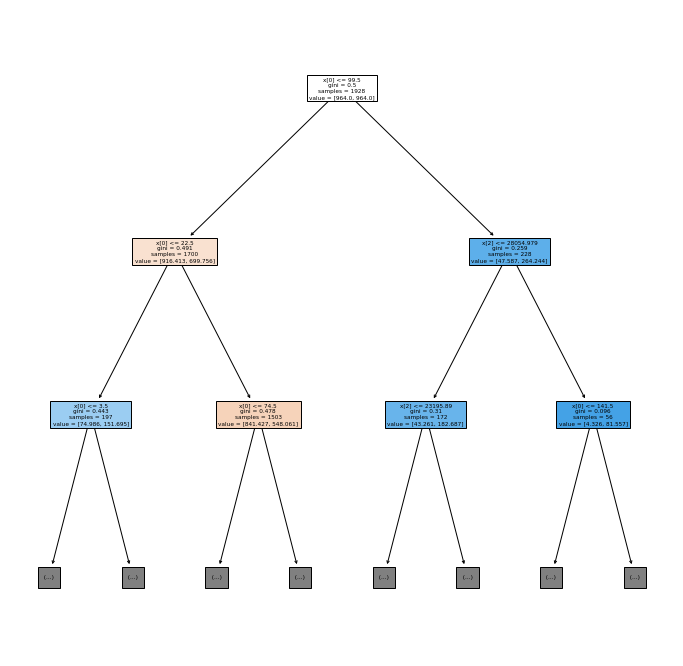

In [ ]:
# Visualizing the Best Decision Tree Model:
fig, ax = plt.subplots(figsize=(12, 12))
plot_tree(model, filled=True, ax=ax, max_depth=2)
plt.show()

**Conclusion:**

I used the following hyperparameters for the model:
- `max_depth` - maximum depth of the decision tree;
- `min_samples_split` - minimum number of samples required to split an internal node;
- `max_features` - maximum number of features considered when looking for the best split;
- `class_weight` - class weights.

The highest model accuracy of 0.799 is achieved with `class_weight='balanced'`, `max_depth=3`, `max_features=None`, and `min_samples_split=2`.



In [ ]:
# Investigating Model Overfitting:
acc_train = []
acc_valid = []
for i in range(1, 20):
  model = RandomForestClassifier(random_state=404540, max_depth=i)
  model.fit(features_train, target_train)
  predictions_train = model.predict(features_train)
  acc_train.append(accuracy_score(target_train, predictions_train))
  predictions_valid = model.predict(features_valid)
  acc_valid.append(accuracy_score(target_valid, predictions_valid))

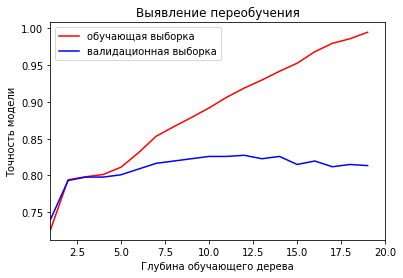

In [ ]:
plt.plot(range(1, 20), acc_train, color='red', label='обучающая выборка')
plt.plot(range(1, 20), acc_valid, color='blue', label='валидационная выборка')
plt.xlabel('Глубина обучающего дерева')
plt.ylabel('Точность модели')
plt.title('Выявление переобучения')
plt.xlim(1, 20)
plt.legend()
plt.show()

The Random Forest is less prone to overfitting, as we can observe from the graph. After a depth of approximately 5, the model's accuracy on the validation set remains relatively stable.

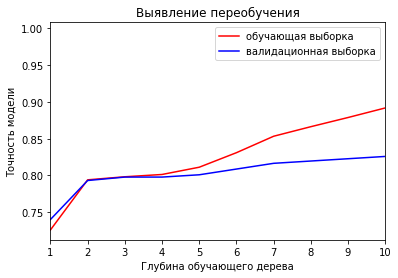

In [ ]:
plt.plot(range(1, 20), acc_train, color='red', label='обучающая выборка')
plt.plot(range(1, 20), acc_valid, color='blue', label='валидационная выборка')
plt.xlabel('Глубина обучающего дерева')
plt.ylabel('Точность модели')
plt.title('Выявление переобучения')
plt.xlim(1, 10)
plt.legend()
plt.show()

Let's zoom in.

In [ ]:
# Investigating the Effectiveness of the Random Forest:
for j in range(2, 6):
    for m in [None, 'auto', 'sqrt', 'log2']:
        for r in range(10, 15):
            model = RandomForestClassifier(random_state=404540, max_depth=9,
                                               min_samples_split=j, max_features=m,
                                               n_estimators=r)
            model.fit(features_train, target_train)
            prediction = model.predict(features_valid)
            acc = accuracy_score(target_valid, prediction)
            if acc > best_acc:
                best_model = model
                best_acc = acc
                best_depth = i

In [ ]:
print(best_model)
print(best_acc)

RandomForestClassifier(max_depth=9, max_features='auto', min_samples_split=3,
                       n_estimators=10, random_state=404540)
0.8258164852255054


**Conclusion:**

I used the following parameters for the model:
- `max_depth` - maximum depth of the decision tree;
- `min_samples_split` - minimum number of samples required to split an internal node;
- `max_features` - maximum number of features considered when looking for the best split;
- `n_estimators` - number of trees in the forest.

The highest model accuracy of 0.826 is achieved with `max_depth=9`, `min_samples_split=3`, `max_features='auto'`, and `n_estimators=10`.

## Testing the Model on the Test Set

In [ ]:
print(best_model)
prediction = best_model.predict(features_test)
print(accuracy_score(target_test, prediction))

RandomForestClassifier(max_depth=9, max_features='auto', min_samples_split=3,
                       n_estimators=10, random_state=404540)
0.8040435458786936


**Conclusion:**

The most accurate model was the: `RandomForestClassifier(max_depth=9, max_features='auto', min_samples_split=3, n_estimators=10, random_state=404540)`.

This result was expected. Random Forest is more accurate compared to a standard decision tree. While a decision tree builds a single tree, Random Forest builds multiple trees and aggregates their results, making the outcome more accurate and less prone to overfitting.

## Checking Model Adequacy

In [ ]:
# Creating a Baseline Model:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train)
prediction_dummy = dummy.predict(features_test)
print(accuracy_score(target_test, prediction_dummy))
# Calculating True Positive Rate:
tn, fp, fn, tp = confusion_matrix(target_test, prediction).ravel()
tpr = tp / (tp+fn)
# Считаем True Negative Rate:
tnr = tn / (tn+fp)
print('Для нашей модели')
print('True Possitive Rate:', tpr)
print('True Negative Rate:', tnr)

0.6936236391912908
Для нашей модели
True Possitive Rate: 0.5177664974619289
True Negative Rate: 0.9304932735426009


**Conclusion:**

The baseline model, which predicts only the most frequent class (0), achieved an accuracy of 0.693. This is significantly lower than the accuracy of the best model, which is 0.804. Therefore, we can conclude that the model has passed the adequacy check. HOWEVER, with a True Positive Rate (TPR) of 0.517, which is relatively low, it would be advisable to implement measures for class balancing.